# Week 3 - CNNs and Cross Entropy

In [15]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
import torchvision.datasets as datasets
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms
from tqdm import tqdm
from torchsummary import summary # courtesy of https://stackoverflow.com/questions/55875279/how-to-get-an-output-dimension-for-each-layer-of-the-neural-network-in-pytorch


In [ ]:
dataset = 'mnist' # Otherwise, suse 'cifar10'

# TODO: PERHAPS USE THIS, PERHAPS NOT
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

if dataset == 'cifar10':
    train_set = datasets.CIFAR10(root='./data', train=True, download=True, transform=ToTensor())
    test_set = datasets.CIFAR10(root='./data', train=False, download=True, transform=ToTensor())

elif dataset == 'mnist':
    train_set = datasets.MNIST(root='./data', train=True, download=True, transform=ToTensor())
    test_set = datasets.MNIST(root='./data', train=False, download=True, transform=ToTensor())



# TODO: Print some stats of the dataset here...
print('Number of training samples:', len(train_set))
print('Number of test samples:', len(test_set))
print('Image shape:', train_set[0][0].shape)
print('Image type:', type(train_set[0][0]))
print('Image min/max:', train_set[0][0].min(), train_set[0][0].max())

In [3]:
# DataLoader(dataset, batch_size=1, shuffle=False, sampler=None,
#            batch_sampler=None, num_workers=0, collate_fn=None,
#            pin_memory=False, drop_last=False, timeout=0,
#            worker_init_fn=None, *, prefetch_factor=2,
#            persistent_workers=False)

train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=16, shuffle=True, collate_fn=None)
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=16, shuffle=False, collate_fn=None)



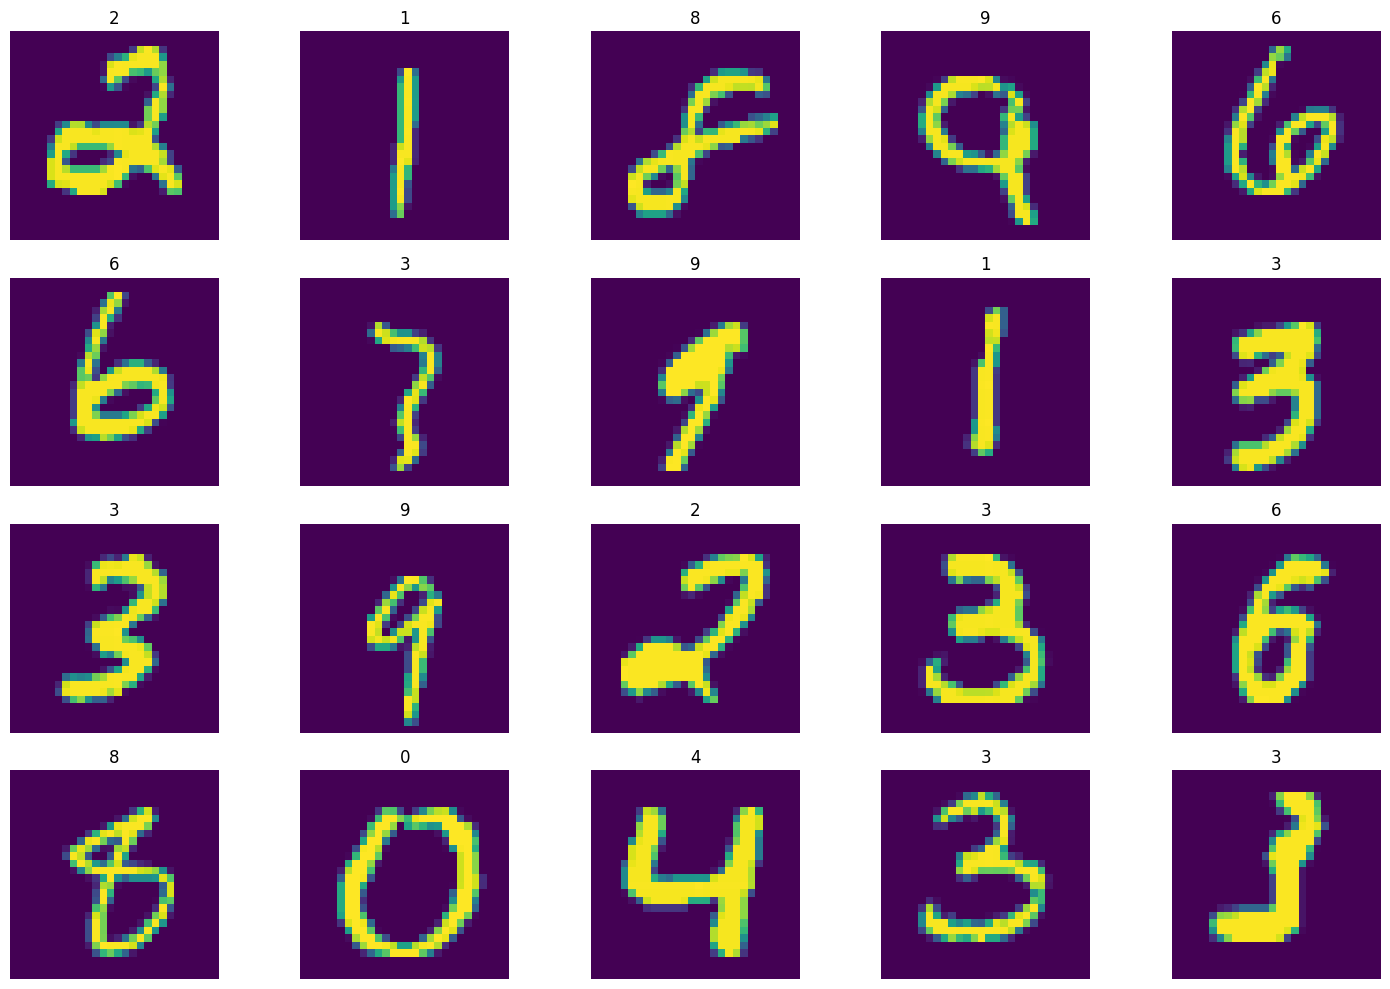

In [4]:
cifar10_classes = {
    0: 'airplane',
    1: 'automobile',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck'
}

num_rows = 4
num_cols = 5
num_images = num_rows * num_cols

# Create a figure to display the images
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))
fig.suptitle('Train Images and their classes', fontsize=20)
axes = axes.flatten()


p = 0
# TODO: Consider if it isn't easier just using variable dataloader size for this bullshit... would save the nested loops, ya'know
for imgs, labels in train_dataloader:
    for img, label in zip(imgs, labels):
        
        if p == num_images:
            continue

        curr_img = img.permute(1, 2, 0).numpy()
        # Normalize the image to the range [0, 1]
        curr_img = (curr_img - curr_img.min()) / (curr_img.max() - curr_img.min())
        axes[p].imshow(curr_img)
        axes[p].axis('off')

        if dataset == 'cifar10':
            axes[p].set_title(cifar10_classes[label.item()], fontsize=12)
        elif dataset == 'mnist':
            axes[p].set_title(label.item(), fontsize=12)

        p += 1

    if p == num_images:
        break

    
plt.tight_layout()
plt.show()


In [23]:
class FFN(torch.nn.Module):
    def __init__(self, train_loader, test_loader, in_features, num_classes, lr=0.001):
        super().__init__()
        
        # self.train_loader = train_loader
        # self.test_loader = test_loader
        self.num_classes = num_classes


        self.layers = nn.Sequential(
            nn.Linear(in_features=in_features, out_features=32),
            nn.ReLU(),
            nn.Linear(in_features=32, out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=num_classes)
        )

        self.criterion = nn.CrossEntropyLoss()

        self.optim = torch.optim.Adam(self.layers.parameters(), lr=lr)
            

    def forward(self, x):
        return self.layers(x.flatten(start_dim=1))

    def train(self, train_dataloader, epochs=1, test_dataloader=None):
        

        for epoch in tqdm(range(epochs)):

            for inputs, targets in train_dataloader:
                
                logits = self.forward(inputs)

                preds = torch.argmax(logits, dim=1)

                loss = self.criterion(logits, targets)

                loss.backward()

                self.optim.step()

                self.optim.zero_grad()
        
                

    def test(self, test_dataloader):
        
        total_acc = 0

        for input_batch, label_batch in test_dataloader:
            # Get predictions
            outs = self(input_batch)

            # Remember, outs are probabilities (so there's 10 for each input)
            # The classification the network wants to assign, must therefore be the probability with the larget value
            # We find that using argmax (dim=1, because dim=0 would be across batch dimension)
            classifications = torch.argmax(outs, dim=1)
            print(classifications)
            total_acc += (classifications == label_batch).sum().item()

        total_acc = total_acc / len(test_dataloader.dataset)

        return total_acc


class CNN(FFN):
    
    def __init__(self, train_loader, test_loader, in_features, num_classes, in_channels=1, lr=0.001):
        super().__init__(train_loader, test_loader, in_features, num_classes)
        

        # Remember here, that the amount of parameters in a convolutional layer
        # Is (n * m * l + 1) * k
        # Where n, m is the kernel size (x, y), l is the input channels, and k is the output channels
        # + 1 is beacuse of a bias term that is done for each input
        # Basically, n * m * l corresponds to kernels mapping to values in another "image"
        # This "image". Each kernel has a bias term unique to it. Each kernel produces one "image", that are then stacked
        # on top of each other, for a total of k images.

        #CONV2D does NOT flip the kernel!!!
        # It doesn't really mattter, since it is just learned anyways...
        # Better to maxpool first, max-pooling and monotonely increasing non-linearities commute. This means that MaxPool(Relu(x)) = Relu(MaxPool(x)) for any input
        # cite - https://stackoverflow.com/questions/35543428/activation-function-after-pooling-layer-or-convolutional-layer

        self.layers = torch.nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=32, kernel_size=3, padding=1), # dim = in
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(in_features=64*6*6, out_features=600),
            nn.Linear(in_features=600, out_features=120),
            nn.Linear(in_features=120, out_features=num_classes)
        )
    def forward(self, x):
        return self.layers(x)

    def forward_checker(self, x):
        print(x.size())

        for layer in self.layers:
            try:
                x = layer(x)
                print(f"After {layer}: ",x.size())
            except: #Do not use base exception!
                print("Oops, that did not work!", BaseException)
                break

        # self.layers = torch.nn.Sequential(
        #     nn.Conv2d(in_channels=in_channels, out_channels=32, kernel_size=3, padding=1),
        #     nn.BatchNorm2d(32),
        #     nn.ReLU(),
        #     nn.MaxPool2d(kernel_size=2, stride=2),
        #     nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
        #     nn.BatchNorm2d(64),
        #     nn.ReLU(),
        #     nn.MaxPool2d(2),
        #     nn.Flatten(),
        #     nn.Linear(in_features=64*6*6, out_features=600),
        #     nn.Dropout1d(0.25),
        #     nn.Linear(in_features=600, out_features=120),
        #     nn.Linear(in_features=120, out_features=num_classes)
        # )


class DiscountVGG:
    def __init__(self):
        pass

    def forward(self, x):
        pass

    def train():
        pass


class LightningVGG:
    pass



model = CNN(None, None, 64, 10, in_channels = 3, lr=0.001)

# summary(model, (3, 64, 64))

model.forward_checker(torch.zeros(16, 3, 64, 64))

torch.Size([16, 3, 64, 64])
After Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)):  torch.Size([16, 32, 64, 64])
After MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False):  torch.Size([16, 32, 32, 32])
After ReLU():  torch.Size([16, 32, 32, 32])
After Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1)):  torch.Size([16, 64, 30, 30])
After MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False):  torch.Size([16, 64, 15, 15])
After ReLU():  torch.Size([16, 64, 15, 15])
After Flatten(start_dim=1, end_dim=-1):  torch.Size([16, 14400])
Oops, that did not work! <class 'BaseException'>


tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0287, 0.0287, 0.0287],
        [0.0000, 0.0000, 0.0000,  ..., 0.0287, 0.0287, 0.0287],
        [0.0000, 0.0000, 0.0000,  ..., 0.0287, 0.0287, 0.0287],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0287, 0.0287, 0.0287],
        [0.0000, 0.0000, 0.0000,  ..., 0.0287, 0.0287, 0.0287],
        [0.0000, 0.0000, 0.0000,  ..., 0.0287, 0.0287, 0.0287]],
       grad_fn=<ViewBackward0>)

In [31]:
# Pretty writer

# TODO:
# Make stdout catcher that works for ipynb (or at least has an option for it) and doesn't break stdout
# Make a prettifier function that runs another function with the stdout capturer, captures the output
# and then writes it using the prettifier code from gpt (formatting and all that) 

# Finally: Consider if you can't make prettywriter a wrapper rather than a context manager

from io import StringIO
import sys
from contextlib import contextmanager
@contextmanager
def capture_stdout():
    """
    context manager encapsulating a pattern for capturing stdout writes
    and restoring sys.stdout even upon exceptions

    Examples:
    >>> with capture_stdout() as get_value:
    >>>     print("here is a print")
    >>>     captured = get_value()
    >>> print('Gotcha: ' + captured)

    >>> with capture_stdout() as get_value:
    >>>     print("here is a print")
    >>>     raise Exception('oh no!')
    >>> print('Does printing still work?')
    """
    # Redirect sys.stdout
    out = StringIO()
    sys.stdout = out
    # Yield a method clients can use to obtain the value
    try:
        yield out.getvalue
    finally:
        # Restore the normal stdout
        sys.stdout = sys.__stdout__

class Capturing(list):
    def __enter__(self):
        self._stdout = sys.stdout
        sys.stdout = self._stringio = StringIO()
        return self
    def __exit__(self, *args):
        self.extend(self._stringio.getvalue().splitlines())
        del self._stringio    # free up some memory
        sys.stdout = self._stdout

def parrot(num=5):
    for i in range(num):
        print("NUMBER:", i)
    
with capture_stdout() as get_value:
    print('here is a print')
    parrot(10)
    captured = get_value()
print("GOTCHA", captured)

print("GOTCHA")


help_strings = [
    ("this is value 1", 42),
    ("this is a longer text for value 2", 3.14),
    ("another value", 100),
    ("short", 5)
]

# Find the maximum length of the help strings
max_length = max(len(help) for help, _ in help_strings)

# Print each help string with its value, aligned in columns
for help, value in help_strings:
    print(f"{help:<{max_length}} : {value}")



In [3]:
import sys
from ipykernel.iostream import OutStream
nb_stdout = sys.stdout
sys.stdout = nb_stdout
print("derp")
print(nb_stdout)



derp


In [11]:
example_input, example_label = next(iter(train_dataloader))

print("Batch size is:", len(example_input))
print("Input dim is (remember, there's also a color channel!):", example_input.shape[1:])

# TODO: Change both below to be not cancerous!
in_features = example_input.flatten(start_dim=1).shape[-1]
num_classes = 10 # 

model = FFN(None, None, in_features=in_features, num_classes=num_classes)

model.train(train_dataloader, epochs=1)


print(model.test(test_dataloader))

Batch size is: 16
Input dim is (remember, there's also a color channel!): torch.Size([1, 28, 28])


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:10<00:00, 10.47s/it]


0.098
